# The neural mass model

In this example, we will learn about the basic of `neurolib`. We will create a two-population mean-field model of exponential integrate-and-fire neurons called the `aln` model. We will learn how to create a `Model`, set some parameters and run a simulation. We will also see how we can easily access the output of each simulation.

## `aln` - the adaptive linear-nonlinear cascade model

The adaptive linear-nonlinear (`aln`) cascade model is a low-dimensional population model of spiking neural networks. Mathematically, it is a dynamical system of non-linear ODEs. The dynamical variables of the system simulated in the `aln` model describe the average firing rate and other **macroscopic variables** of a randomly connected, delay-coupled network of excitatory and inhibitory **adative exponential integrate-and-fire neurons (AdEx)** with non-linear synaptic currents. 

Ultimately, the model is a result of various steps of model reduction starting from the Fokker-Planck equation of the AdEx neuron subject to white noise input at many steps of input means $\mu$ and variances $\sigma$. The resulting mean firing rates and mean membrane potentials are then stored in a lookup table and serve as the nonlinear firing rate transfer function, $r = \Phi(\mu, \sigma)$. 

## Basic use

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [2]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np
import scipy

# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

## Simulating a single `aln` node

To create a single node, we simply instanciate the model 
without any arguments. 

In [3]:
# Create the model
aln = ALNModel()

# Each model comes with a set of default parameters which are are a dictionary. 
# Let's change the parameter that controls the duration of a simulation to 10s.
aln.params['duration'] = 10.0 * 1000  

# For convenience, we could also use:
aln.params.duration = 10.0 * 1000

# In the aln model an Ornstein-Uhlenbeck process is simulated in parallel
# as the source of input noise fluctuations. Here we can set the variance
# of the process. 
# For more info: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process 
# Let's add some noise.
aln.params['sigma_ou'] = 0.1

# Finally, we run the model
aln.run()

### Accessing the outputs

Accessing the outputs is straight-forward. Every model's outputs
are stored in the `model.outputs` attribute. According to the specific
name of each of the model's outputs, they can also be accessed as a 
key of the Model object, i.e. `aln['rates_exc']`.

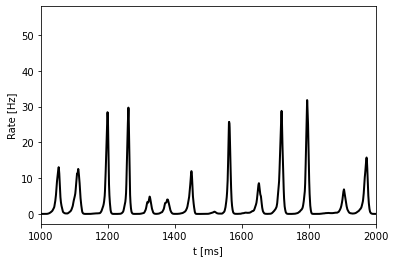

In [4]:
plt.plot(aln['t'], aln['rates_exc'].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(1000, 2000);

In [5]:
# Outputs are also available as an xr DataArray
xr = aln.xr()
print(xr.dims)
# outputs can also be accessed via attributes in dot.notation
print("rates_exc", aln.rates_exc)

('output', 'space', 'time')
rates_exc [[0.00083414 0.00077196 0.0007099  ... 0.07084256 0.0725305  0.07414962]]


### Bifurcation diagram

Bifurcation diagrams can give us an overview of how different parameters of the model affect its dynamics. The simplest method for drawing a bifurcation diagram is to simply change relevant parameters step by step and record the model's behavior in response to these changes. In this example, we want to see how the model's dynamics changes with respect to the **external input currents** to the excitatory population. These input currents could be due to couplings with other nodes in a brain network or we could model other factors like external electrical stimulation. 

Below, you can see a schematic of the `aln` model. As you can see, a single node consists of one excitatory (red) and one inhibitory population (blue). The parameter that controls the mean input to the excitatory population is $\mu_{E}$ or `aln.params["mue_ext_mean"]` .

<p align="center">
  <img src="../resources/aln.png" width="400">
</p>

Let's first decrease the duration of a single run so we can scan the parameter space a bit faster and let's also disable the noisy input.

In [6]:
aln.params['duration'] = 2.0 * 1000  
aln.params['sigma_ou'] = 0.0

Let's fix the input to the inhibitory population:

In [7]:
aln.params['mui_ext_mean'] = 0.5

We draw a one-dimensional bifurcation diagram, so it is enough to loop through different values of `mue_ext_mean` and record the minimum and maximum of the rate for each parameter.

In [8]:
max_rate_e = []
min_rate_e = []
# these are the different input values that we want to scan
mue_inputs = np.linspace(0, 2, 50)
for mue in mue_inputs:
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    aln.params['mue_ext_mean'] = mue
    aln.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_rate_e.append(np.max(aln.output[0, -int(1000/aln.params['dt']):]))
    min_rate_e.append(np.min(aln.output[0, -int(1000/aln.params['dt']):]))

Let's plot the results!

Text(0, 0.5, 'Min / max firing rate')

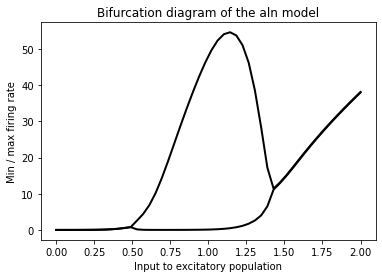

In [9]:
plt.plot(mue_inputs, max_rate_e, c='k', lw = 2)
plt.plot(mue_inputs, min_rate_e, c='k', lw = 2)
plt.title("Bifurcation diagram of the aln model")
plt.xlabel("Input to excitatory population")
plt.ylabel("Min / max firing rate")

## Whole-brain model

`neurolib` comes with some example datasets for exploring its functionality. Please be aware that these datasets are not tested and should not be used for your research, only for experimentation with the software.

A dataset for whole-brain modeling can consists of the following parts:

* A structural connectivity matrix capturing the synaptic connection strengths between brain areas, often derived from DTI tractography of the whole brain. The connectome is then typically parcellated in a preferred atlas (for exapmle the AAL2 atlas) and the number of axonal fibers connecting each brain area with every other area is counted. This number serves as a indication of the synaptic coupling strengths between the areas of the brain. 
* A delay matrix which can be calculated from the average length of the axonal fibers connecting each brain area with another.
* A set of functional data that can act as a target for model optimization. Resting-state fMRI offers an easy and fairly unbiased way for calibrating whole-brain models. EEG data could be used as well.

We can load a `Dataset` by passing the name of it in the constructor. 

In [10]:
from neurolib.utils.loadData import Dataset
ds = Dataset("gw")

We now create the `aln` model with a structural connectivity matrix and a delay matrix. In order to achieve a good fit of the BOLD activity to the empirical data, the model has to run for quite a while. A a rule of thumb, a simulation of resting-state BOLD activity should not be shorter than 3 minutes and preferrably longer than 5 minutes real time. If the empirical recordings are for example 10 minues long, ideally, a simulation of 10 minutes would be used to compare the output of the model to the resting state recording.

In [11]:
aln = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

aln.params['duration'] = 0.2*60*1000 
# Info: value 0.2*60*1000 is low for testing
# use 5*60*1000 for real simulation

After some optimization to the resting-state fMRI data of the dataset, we 
found a set of parameters that creates interesting whole-brain dynamics. 
We set the mean input of the excitatory and the inhibitory population to be 
close to the E-I limit cycle.

In [12]:
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
# We set an appropriate level of noise
aln.params['sigma_ou'] = 0.09
# And turn on adaptation with a low value of spike-triggered adaptation currents.
aln.params['b'] = 5.0

Let's have a look what the data looks like. We can access the
data of each model by calling its internal attrivbutes.
Here, we plot the structural connectivity matrix by calling 
`aln.params['Cmat']` and fiber length matrix by calling 
`aln.params['lengthMat']`.
Of course, we can also access the dataset using the `Dataset`
object itself. For example the functional conencity matrices 
of the BOLD timeseries in the datasets are given as list with 
`ds.FCs`.

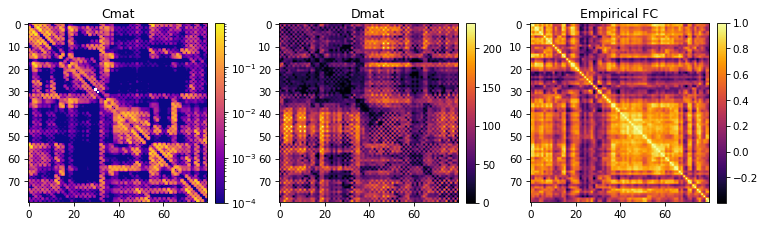

In [13]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 3, figsize=(12,8), dpi=75)
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(aln.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(aln.params['Cmat'])))
axs[0].set_title("Cmat")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(aln.params['lengthMat'], cmap='inferno')
axs[1].set_title("Dmat")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(ds.FCs[0], cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)

### Run model

We run the model with bold simulation by using `bold=True`. 
This simulates the Balloon-Windkessel BOLD model in parallel to
the neural population model in order to estimate the blood oxigen
levels of the underlying neural activity. The output of the `bold`
model can be used to compare the simulated data to empirical fMRI 
data (resting-state fMRI for example).

To save (a lot of) RAM, we can run the simulation in `chunkwise` mode.
In this mode, the model will be simulated for a length of `chunksize` 
steps (not time in ms, but actual integration steps!), and the output
of that chunk will be used to automatically reinitiate the model with 
the appropriate initial conditions. This allows for a serial continuation
of the model without having to store all the data in memory and is 
particularly useful for very long and many parallel simulations.

In [18]:
aln.run(chunkwise=True, chunksize = 100000, bold=True)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.6 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    5.4 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation s

KeyboardInterrupt: 

## Results

The outputs of the model can be accessed using the attribute `model.outputs`

In [15]:
aln.outputs

{'t': array([1.0000e-01, 2.0000e-01, 3.0000e-01, ..., 1.9998e+03, 1.9999e+03,
        2.0000e+03]),
 'rates_exc': array([[0.07270224, 0.07417407, 0.07562513, ..., 0.03825422, 0.03882716,
         0.0394015 ],
        [0.00130058, 0.00129997, 0.00129738, ..., 0.6942445 , 0.68599914,
         0.67858414],
        [0.02745987, 0.02683287, 0.02627354, ..., 0.03794489, 0.0379876 ,
         0.03786139],
        ...,
        [0.00138572, 0.00135039, 0.00131561, ..., 0.01149693, 0.01128196,
         0.01110015],
        [0.06169564, 0.06203184, 0.0624143 , ..., 0.0570454 , 0.05737515,
         0.05761372],
        [0.44030658, 0.43127285, 0.42331134, ..., 0.01198853, 0.0117489 ,
         0.01152402]]),
 'rates_inh': array([[ 7.29361181,  7.36970274,  7.45982108, ...,  7.59467434,
          7.65484933,  7.70364255],
        [ 7.87501919,  7.90590012,  7.92523857, ..., 10.04214849,
         10.12536687, 10.18408128],
        [10.22259739, 10.10995055,  9.97492154, ...,  7.2997738 ,
          7.2

For convenience, they can also be accessed directly using attributes of the model with the outputs name, like `aln.rates_exc`. The outputs are also available as xr DataArrays as `aln.xr()`.

The since we used `bold=True` to simulate BOLD, we can also access `aln.BOLD.BOLD` for the actual BOLD activity, and `aln.BOLD.t` for the time steps of the BOLD simulation (which are downsampled to `0.5 Hz` by default).

### Plot simulated activity

C:\Users\janak\anaconda3\envs\mne\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\janak\anaconda3\envs\mne\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\janak\anaconda3\envs\mne\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\janak\AppData\Local\Temp\ipykernel_27252\1592196077.py:4: UserWarning: Attempting to set identical left == right == 10000.1 results in singular transformations; automatically expanding.
  axs[1].imshow(scipy.stats.mstats.zscore(aln.BOLD.BOLD[:, aln.BOLD.t_BOLD>10000], axis=1), aspect='auto', extent=[aln.BOLD.t_BOLD[aln.BOLD.t_BOLD>10000][0], aln.BOLD.t_BOLD[-1], 0, aln.params['N']]);


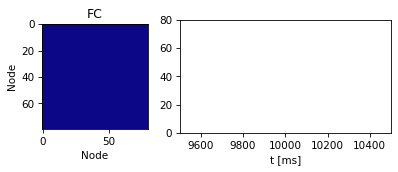

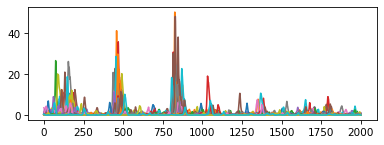

In [16]:
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
axs[0].imshow(func.fc(aln.BOLD.BOLD[:, 5:]))
axs[1].imshow(scipy.stats.mstats.zscore(aln.BOLD.BOLD[:, aln.BOLD.t_BOLD>10000], axis=1), aspect='auto', extent=[aln.BOLD.t_BOLD[aln.BOLD.t_BOLD>10000][0], aln.BOLD.t_BOLD[-1], 0, aln.params['N']]);

axs[0].set_title("FC")
axs[0].set_xlabel("Node")
axs[0].set_ylabel("Node")
axs[1].set_xlabel("t [ms]")

# the results of the model are also accesible through an xarray DataArray
fig, axs = plt.subplots(1, 1, figsize=(6, 2), dpi=75)
plt.plot(aln.xr().time, aln.xr().loc['rates_exc'].T);

### Correlation of simulated BOLD to empirical data

We can compute the element-wise Pearson correlation of the functional connectivity matrices of the simulated data to the empirical data to estimate how well the model captures the inter-areal BOLD correlations found in empirical resting-state recordings. 

In [17]:
scores = [func.matrix_correlation(func.fc(aln.BOLD.BOLD[:, 5:]), fcemp) for fcemp in ds.FCs]

print("Correlation per subject:", [f"{s:.2}" for s in scores])
print(f"Mean FC/FC correlation: {np.mean(scores):.2}")


Correlation per subject: ['nan', 'nan', 'nan', 'nan', 'nan']
Mean FC/FC correlation: nan


C:\Users\janak\anaconda3\envs\mne\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\janak\anaconda3\envs\mne\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
